In [1]:
import onnxruntime as rt
import uproot
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

2025-02-07 11:43:14.516844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
columns = [
    "era",
    "higgs1_reco_pt",
    "higgs1_reco_eta",
    "higgs1_reco_phi",
    "higgs1_reco_mass",
    "higgs2_reco_pt",
    "higgs2_reco_eta",
    "higgs2_reco_phi",
    "higgs2_reco_mass",
    "HT",
    "higgs1_DeltaRjj",
    "higgs2_DeltaRjj",
    "minDeltaR_Higgjj",
    "maxDeltaR_Higgjj",
    "higgs1_helicityCosTheta",
    "higgs2_helicityCosTheta",
    "hh_CosThetaStar_CS",
    "hh_vec_mass",
    "hh_vec_pt",
    "hh_vec_eta",
    "hh_vec_DeltaR",
    "hh_vec_DeltaPhi",
    "hh_vec_DeltaEta",
    "higgs1_reco_jet1_pt",
    "higgs1_reco_jet1_eta",
    "higgs1_reco_jet1_phi",
    "higgs1_reco_jet1_mass",
    "higgs1_reco_jet2_pt",
    "higgs1_reco_jet2_eta",
    "higgs1_reco_jet2_phi",
    "higgs1_reco_jet2_mass",
    "higgs2_reco_jet1_pt",
    "higgs2_reco_jet1_eta",
    "higgs2_reco_jet1_phi",
    "higgs2_reco_jet1_mass",
    "higgs2_reco_jet2_pt",
    "higgs2_reco_jet2_eta",
    "higgs2_reco_jet2_phi",
    "higgs2_reco_jet2_mass",
    "add_jet1pt_pt",
    "add_jet1pt_eta",
    "add_jet1pt_phi",
    "add_jet1pt_mass",
    "sigma_over_higgs1_reco_mass",
    "sigma_over_higgs2_reco_mass",
]
main_dir='/pnfs/psi.ch/cms/trivcat/store/user/mmalucch/keras_models_morphing'


In [3]:
input_root=f'/pnfs/psi.ch/cms/trivcat/store/user/mmalucch/JetMET_2022EE_2b_signal_region_to_4b_soumya_january2025.root'
tree=uproot.open(input_root)["tree"]
print(tree.keys())


['era', 'event', 'HT', 'jet_pt', 'jet_pt_raw', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_mass_raw', 'jet_deepjet_probBVsAll', 'jet_pnet_probBVsAll', 'jet_pnet_probTauVsJet', 'jet_pnet_probb', 'jet_pnet_probc', 'jet_pnet_probuds', 'jet_pnet_probtauh', 'jet_pnet_ptcorr', 'jet_pnet_ptnu', 'jet_pnet_ptres', 'jet_pnet_jec_L1L2L3', 'jet_pnet_jec_L2Rel', 'jet_pnet_jec_L2L3Res', 'btag_cat', 'weight', 'is_boosted', 'weight_dnn', 'sigma_higgs1', 'sigma_over_higgs1_reco_mass', 'higgs1_reco_pt', 'higgs1_reco_eta', 'higgs1_reco_phi', 'higgs1_reco_mass', 'sigma_higgs2', 'sigma_over_higgs2_reco_mass', 'higgs2_reco_pt', 'higgs2_reco_eta', 'higgs2_reco_phi', 'higgs2_reco_mass', 'hh_vec_mass', 'hh_vec_pt', 'hh_vec_eta', 'hh_vec_phi', 'hh_vec_DeltaR', 'hh_vec_DeltaPhi', 'hh_vec_DeltaEta', 'hh_vec_ptOmass', 'njet', 'higgs1_reco_jet1_pt', 'higgs1_reco_jet1_eta', 'higgs1_reco_jet1_phi', 'higgs1_reco_jet1_mass', 'higgs1_reco_jet2_pt', 'higgs1_reco_jet2_eta', 'higgs1_reco_jet2_phi', 'higgs1_reco_jet2_mass', 'hig

get the columns from the tree

In [4]:
input_data_dict = tree.arrays(columns, library="np")
print(input_data_dict, type(input_data_dict), len(input_data_dict['era']))


{'era': array([1, 1, 1, ..., 1, 1, 1], dtype=int32), 'higgs1_reco_pt': array([114.53315, 152.08524, 178.58029, ..., 267.7927 , 284.75745,
       204.16527], dtype=float32), 'higgs1_reco_eta': array([-0.5849934 ,  0.05618766, -1.7868915 , ...,  1.5282159 ,
       -0.09514122, -1.9165224 ], dtype=float32), 'higgs1_reco_phi': array([ 0.51116806,  0.9747667 ,  2.7567482 , ..., -1.0621026 ,
        2.113538  ,  1.722217  ], dtype=float32), 'higgs1_reco_mass': array([127.91875 , 104.56954 , 134.2589  , ..., 118.74667 , 138.50037 ,
       118.519966], dtype=float32), 'higgs2_reco_pt': array([ 97.30428 , 104.97775 , 106.02391 , ..., 246.28754 , 190.73148 ,
        59.150402], dtype=float32), 'higgs2_reco_eta': array([-0.9684525 ,  1.3636122 , -0.53399426, ..., -0.13717638,
       -1.3410919 ,  1.5108076 ], dtype=float32), 'higgs2_reco_phi': array([ 1.3662084 , -1.4257993 , -0.10356549, ...,  1.9001577 ,
       -0.87525326, -1.5235088 ], dtype=float32), 'higgs2_reco_mass': array([120.70619, 101

In [5]:
n_events = -1
# get the input data as a numpy array
input_data = np.array([input_data_dict[col][:n_events] for col in columns], dtype=np.float32).T
print(input_data, type(input_data))
weight_dnn = np.array(tree['weight_dnn'].array()[:n_events])
input_tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
print(input_tensor, type(input_tensor))


[[ 1.0000000e+00  1.1453315e+02 -5.8499342e-01 ... -1.0000000e+01
   1.0990235e-01  6.8167850e-02]
 [ 1.0000000e+00  1.5208524e+02  5.6187656e-02 ...  1.1291707e+01
   1.3171081e-01  9.2042722e-02]
 [ 1.0000000e+00  1.7858029e+02 -1.7868915e+00 ...  1.2792351e+01
   7.4768290e-02  1.0651090e-01]
 ...
 [ 1.0000000e+00  3.5765292e+02  5.2900183e-01 ...  2.3197163e+01
   5.3616837e-02  9.6934266e-02]
 [ 1.0000000e+00  2.6779269e+02  1.5282159e+00 ...  5.0211763e+00
   7.7601612e-02  6.1551124e-02]
 [ 1.0000000e+00  2.8475745e+02 -9.5141225e-02 ... -1.0000000e+01
   1.0183499e-01  7.8228682e-02]] <class 'numpy.ndarray'>
tf.Tensor(
[[ 1.0000000e+00  1.1453315e+02 -5.8499342e-01 ... -1.0000000e+01
   1.0990235e-01  6.8167850e-02]
 [ 1.0000000e+00  1.5208524e+02  5.6187656e-02 ...  1.1291707e+01
   1.3171081e-01  9.2042722e-02]
 [ 1.0000000e+00  1.7858029e+02 -1.7868915e+00 ...  1.2792351e+01
   7.4768290e-02  1.0651090e-01]
 ...
 [ 1.0000000e+00  3.5765292e+02  5.2900183e-01 ...  2.3197163e+

2025-02-07 11:43:34.576821: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 392439420 exceeds 10% of free system memory.


In [6]:
session_combine = rt.InferenceSession(
    f"{main_dir}/average_model_from_keras.onnx",
    providers=rt.get_available_providers()
)
# print the input/putput name and shape
input_name=[input.name for input in session_combine.get_inputs()]
output_name=[output.name for output in session_combine.get_outputs()]
print("Inputs name:", input_name)
print("Outputs name:", output_name)

input_shape=[input.shape for input in session_combine.get_inputs()]
output_shape=[output.shape for output in session_combine.get_outputs()]
print("Inputs shape:", input_shape)
print("Outputs shape:", output_shape)

input_example = {input_name[0]: input_data}

output = session_combine.run(output_name, input_example)[0]
print(output)
print(output*0.018824706 )
print(weight_dnn)
print(output/weight_dnn)

print((output*0.018824706)/weight_dnn)


Inputs name: ['args_0']
Outputs name: ['avg_w']
Inputs shape: [['N', 45]]
Outputs shape: [[None]]
[0.12036134 0.11755123 0.42651352 ... 1.7989094  0.27185857 1.3240389 ]
[0.00226577 0.00221287 0.00802899 ... 0.03386394 0.00511766 0.02492464]
[0.00226577 0.00221286 0.00802899 ... 0.03386394 0.00511766 0.02492465]
[53.121693 53.12176  53.1217   ... 53.12168  53.1217   53.12167 ]
[1.0000004  1.0000015  1.0000004  ... 1.         1.0000004  0.99999976]


/tmp/ipykernel_54152/164810726.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


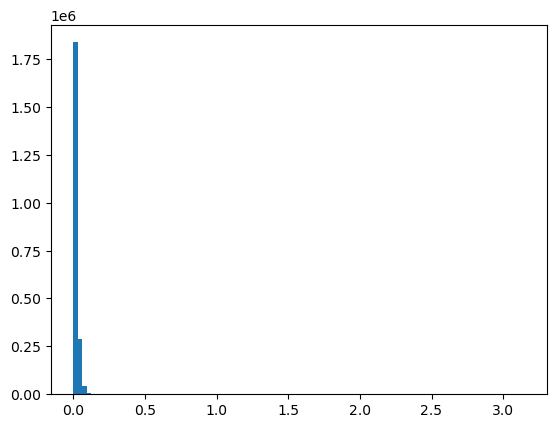

In [7]:
# plot the histogram of weight_dnn
fig, ax = plt.subplots()
plt.hist(weight_dnn, bins=100)
fig.show()

In [9]:
print(max(weight_dnn))

3.14648
